# **Computing Assignment 2**




#Importing required libraries

In [67]:
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import scipy as sp
from scipy import signal
from scipy.fftpack import fft
from scipy.io import wavfile

#Extracting the given input file

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
WAV file:  Fs = 8000, x.shape = (720,), x.dtype = float32


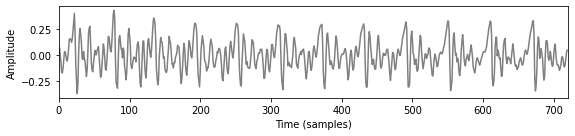

In [68]:
drive.mount('/content/gdrive')
def print_plot_play(x, Fs, text=''):
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

# Read wav
fn_wav = os.path.join('/content/gdrive/MyDrive/aa.wav')

data, Fs = librosa.load(fn_wav, sr=None)
print_plot_play(x=data, Fs=Fs, text='WAV file: ')

#Defining pre-emphasis filter

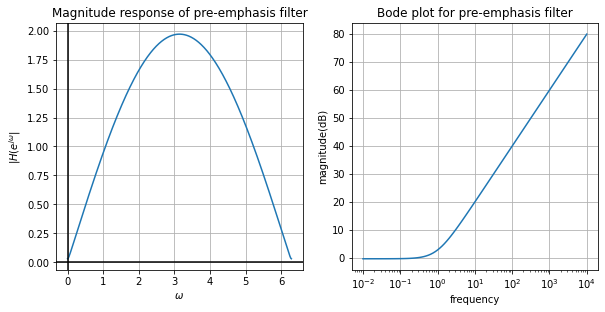

In [69]:
"""Function to define pre-emphasis filter"""
def filter(w):
  Z=np.exp(1j*w)
  '''Writing given transfer function'''
  H=1-0.97*Z**(-1)
  return H
w=np.arange(0,2*np.pi,0.01)
magnitude=np.abs(filter(w))
phase=np.angle(filter(w))
figure = plt.figure(figsize = [15,10])
figure.add_subplot(2,3,1)
plt.plot(w,magnitude)
plt.title("Magnitude response of pre-emphasis filter")
plt.xlabel("$\omega$")
plt.ylabel("$|H(e^{j\omega}|$")
plt.axvline(color = "black")
plt.axhline(color = "black")
plt.grid()
"""Plotting bode plot for pre-emphasis filter"""
p_emph=[1,-0.97]
sys = signal.TransferFunction(p_emph,[1])
w, mag, phase = signal.bode(sys)
figure.add_subplot(2,3,2)
plt.semilogx(w, mag)    # Bode magnitude plot
plt.title('Bode plot for pre-emphasis filter')
plt.xlabel('frequency')
plt.ylabel('magnitude(dB)')
plt.grid()
w=np.arange(0,2*np.pi,0.01)


#Applying pre-emphasis on the given input signal

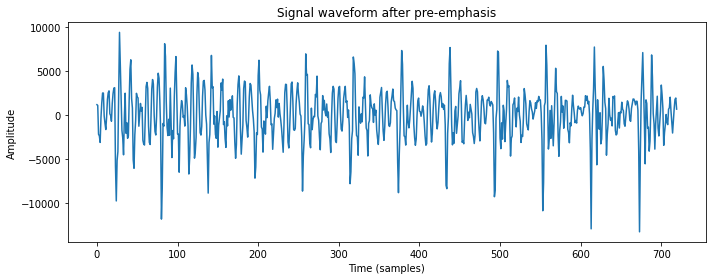

In [70]:
fs ,data = wavfile.read('/content/gdrive/MyDrive/aa.wav')
pre_emphasis = 0.97
emphasized_signal = np.append(data[0], data[1:] - pre_emphasis * data[:-1])
plt.figure(figsize=(10, 4))
plt.plot(emphasized_signal)
plt.title('Signal waveform after pre-emphasis')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#Windowing the signal obtained after pre-emphasis with the hamming window of 30ms duration.

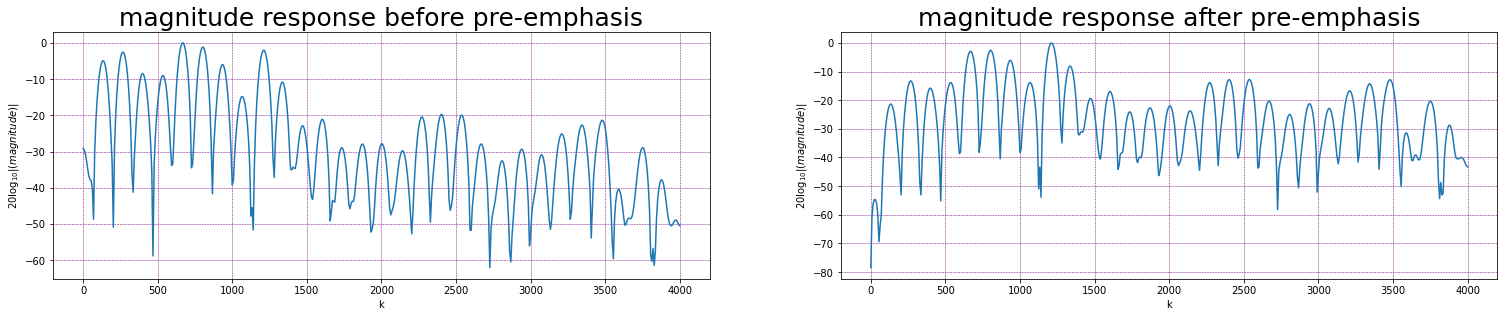

In [71]:

""" function for performing short time fourier transform"""
def dft(x,w,N,M):

  """ Here we give window and input sound signal along with dft 
  length and window length as input and we get windowed signal as output"""
  hn=(N//2)+1                  # size of positive spectrum including sample 0
  hm1=(np.size(w)+1)//2        # half analysis window size by rounding
  hm2=np.size(w)//2            # half analysis window size by floor
  fftbuffer=np.zeros(N)        # Initializing zero buffer of dft length
  w=w/np.sum(w)                # normalizing analysis window
  """choosing the input frame from the middle of
   input sequence"""
  f=400+M                     
  x=x[400:f]                  
  mul=x*w                      # windowing the input sequence
  """ placing the windowed sequence in the zero buffer"""
  fftbuffer[:hm1]=mul[hm2:]
  fftbuffer[-hm2:]=mul[:hm2]
  X=fft(fftbuffer)
  absX=abs(X[:hn])            # taking absolute value of output magnitude
  absX[absX<np.finfo(float).eps]=np.finfo(float).eps   # checking for zero values in magnitude before taking log
  # mag=-1*20*np.log10(absX)
  mag=20*np.log10(absX)
  return mag,mul



"""Windowed output for window of length 30 msec"""
N=1024
Fs=8000
duration=0.03
M=int(duration*Fs)
hamming_window=signal.get_window('hamming',M)
x,time_x=dft(data,hamming_window,N,M)
emph_x,time_x=dft(emphasized_signal,hamming_window,N,M)
figure=plt.figure(figsize=(40,10))
figure.add_subplot(2,3,1)
plt.title("magnitude response before pre-emphasis",fontsize = 25)
plt.plot(np.arange(0,(Fs/2)+1,Fs/float(N)),x-max(x))
plt.xlabel('k')
plt.ylabel('$20\log_{10}|(magnitude)|$')
plt.grid(color='purple',linestyle='--',linewidth=0.5)

figure.add_subplot(2,3,2)
plt.title("magnitude response after pre-emphasis",fontsize = 25)
plt.plot(np.arange(0,(Fs/2)+1,Fs/float(N)),emph_x-max(emph_x))
plt.xlabel('k')
plt.ylabel('$20\log_{10}|(magnitude)|$')
plt.grid(color='purple',linestyle='--',linewidth=0.5)

#From the above plots of the magnitude response vs frequency, we can clearly see that after pre-emphasis high frequency components are boosted.

#We can also calculate pitch of given input by:-

We have 7 harmonics present in range $k\to(0,1000)$ which are represented by the peaks in the magnitude spectrum.

$7*F0$(Fundamental frequency or pitch)=$1000$

$F_0=\frac{1000}{7}=142.85 Hz$

#Linear Predictive Analysis

$S(n)=a_{1}S(n-1)+A_{2}S(n-2)+..........+a_{P}S(n-P)$

where, P=order of filter coefficients

**From the above equation we can see that our current speech sample $S(n)$ is the linear combination of LP coefficients $(a_{1}, a_{2}, a_{3},......a_{P})$ multiplied with the previous samples.**


Here, we will first compute autocorrelation coefficients and with their help we will compute LP coefficients by Levinson-Durbin prediction algorithm and also calculate error between oroginal and computed speech signal.

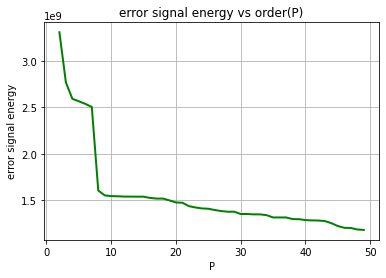

In [72]:
"""Function for Applying Levison-Durbin prediction algorithm"""
def lpc(y, m):
    """Return Auto-correlation coefficients, error and m linear 
    predictive coefficients for sequence y using Levinson-Durbin prediction algorithm"""
    #step 1: compute autoregression coefficients R_0, ..., R_m
    R = [y.dot(y)] 
    if R[0] == 0:
        return [1] + [0] * (m-2) + [-1]
    else:
        for i in range(1, m + 1):
            r = y[i:].dot(y[:-i])
            R.append(r)
        R = np.array(R)
    #step 2: compute LP coeff's A_0,A_1....., A_m
        A = np.array([1, -R[1] / R[0]])
        E = R[0] + R[1] * A[1]
        for k in range(1, m):
            if (E == 0):
                E = 10e-17
            alpha = - A[:k+1].dot(R[k+1:0:-1]) / E
            A = np.hstack([A,0])
            A = A + alpha * A[::-1]
            E *= (1 - alpha**2)
        return A,E,R
error=[]
order=np.arange(2,50,1)
for i in range(0,48):
  a,e,r=lpc(emphasized_signal,order[i])
  error.append(e)
  """Plotting the error signal energy vs order of filter"""
plt.plot(order,error, color='green', linestyle='solid',
     linewidth=2, markersize=12)
plt.title('error signal energy vs order(P)')
plt.xlabel('P')
plt.ylabel('error signal energy')
plt.grid()


#1: From the above plot we can clearly observe that error is decreasing with increase in the order of the filter. This is because with increase in order, accuracy of predicted envelope to match the original envelope increases and it tries to match not only the peaks but also the vallies.

#2: We can also observe from the plot that error drastically reduces for p=8(approx) so it is good for using in further analysis and sythesis.

#Function for pole zero plot of the estimated all-pole filter for p=6,10

array([ 1.        , -0.60269868,  0.13202645,  0.1973542 ,  0.54577675,
       -0.06956656,  0.03197358, -0.26886119,  0.67745195, -0.13643513,
       -0.07115696])

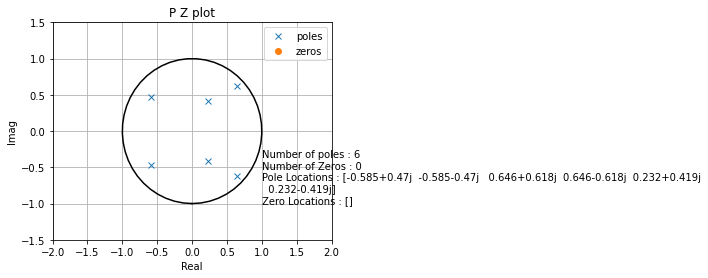

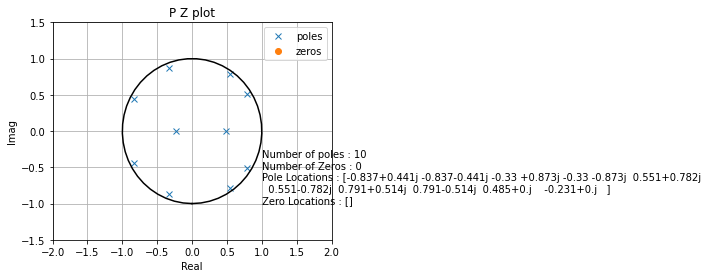

In [73]:
from scipy.signal import tf2zpk
def PoleZeroPlot(b, a,plots=True):
  (zeros,poles,gain) = tf2zpk(b, a)
  angle = np.linspace(-np.pi,np.pi,50)
  cirx = np.sin(angle)
  ciry = np.cos(angle)
  if plots:
    plt.figure()
    plt.plot(poles.real, poles.imag, 'x', zeros.real, zeros.imag, 'o', cirx,ciry, 'k-')
    plt.xlim((-2, 2))
    plt.xlabel('Real')
    plt.ylim((-1.5, 1.5))
    plt.ylabel('Imag')
    plt.title("P Z plot")
    plt.legend(["poles","zeros"])
    text = "Number of poles : {0} \nNumber of Zeros : {1} \nPole Locations : {2} \nZero Locations : {3}".format(len(poles),len(zeros),np.round(poles,3),np.round(zeros,3))
    plt.text(1,-1,text)
    plt.gcf().set_figwidth(5)
    plt.grid()
  return (zeros,poles,gain)

order= 2
a1,e1,r1=lpc(emphasized_signal,order)
z1,p1,g1=PoleZeroPlot([1],a1,False)
order= 4
a2,e2,r2=lpc(emphasized_signal,order)
z2,p2,g2=PoleZeroPlot([1],a2,False)
order= 6
a3,e3,r3=lpc(emphasized_signal,order)
z3,p3,g3=PoleZeroPlot([1],a3,True)
order= 8
a4,e4,r4=lpc(emphasized_signal,order)
z4,p4,g4=PoleZeroPlot([1],a4,False)
order= 10
a5,e5,r5=lpc(emphasized_signal,order)
z5,p5,g5=PoleZeroPlot([1],a5,True)
a5


#1: From the pole zero plots of estimated all pole filter for p = 6,10, we can observe that all the poles are lying inside the unit circle and we already know that for poles lying inside unit circle ROC will include unit circle for causal system and thus the system is stable.


#2: So clearly our estimated all pole filter is stable.


#Computing gain of filter for p=[2,4,6,8,10]

$G^{2}=E_{min}=r(0)-\sum_{k\rightarrow 1}^{p} a_{k}r(k)$

In [74]:
G1=round(np.sqrt(e1),4)
G2=round(np.sqrt(e2),4)
G3=round(np.sqrt(e3),4)
G4=round(np.sqrt(e4),4)
G5=round(np.sqrt(e5),4)
G=[G1,G2,G3,G4,G5]
print('Gain for P=[2,4,6,8,10] is:',G)

Gain for P=[2,4,6,8,10] is: [57518.4027, 50920.3333, 50384.5428, 40088.5014, 39332.0482]


#Plotting the LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for each order "p".

Plotting magnitude spectrum for P=[2,4,6,8,10]


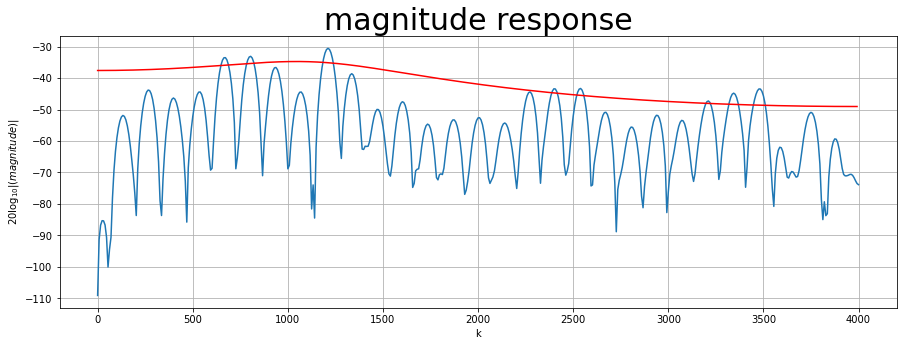

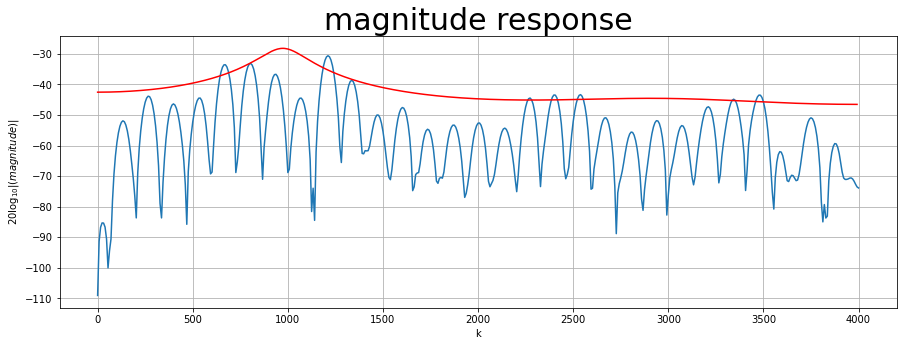

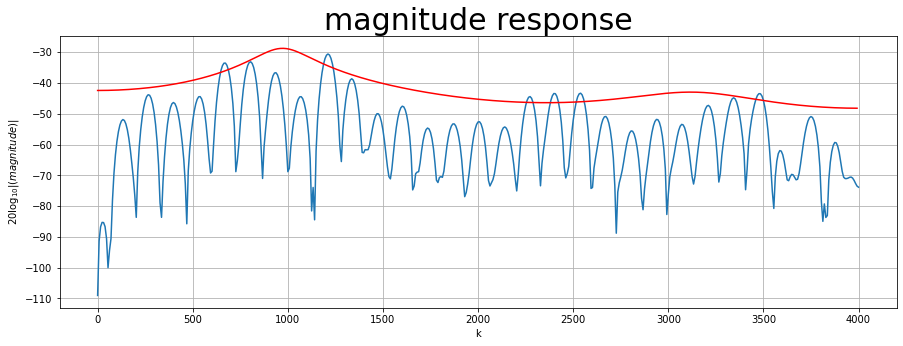

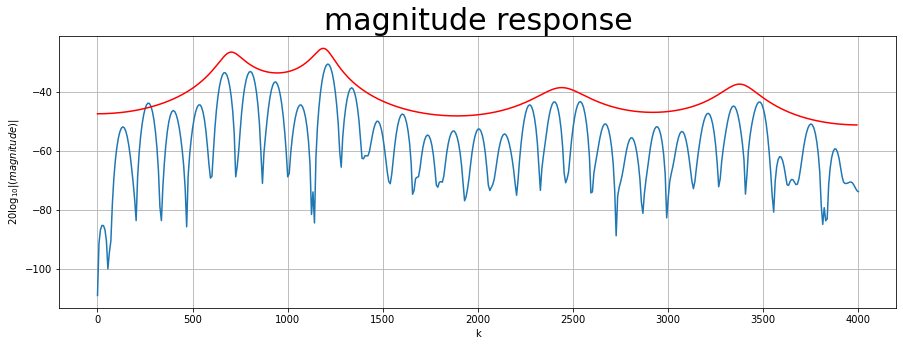

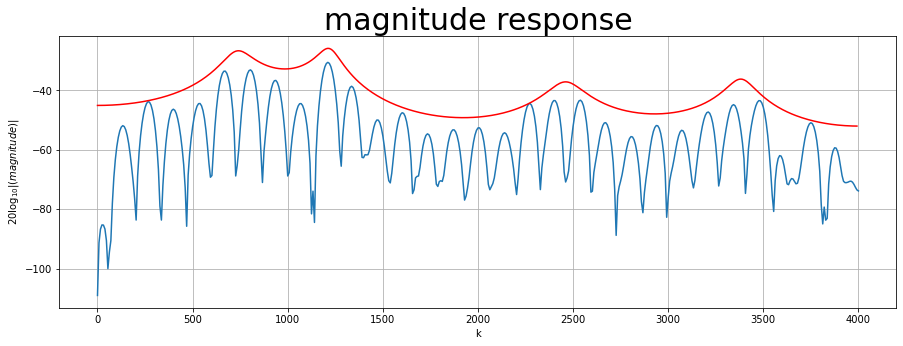

In [75]:
def plots(w,h,plots=True):
  plt.figure(figsize=[15,5])
  if plots:
    plt.plot(np.arange(0,(Fs/2)+1,Fs/float(N)),(emph_x-1.5*max(emph_x)))
  plt.plot(w,20*np.log10(0.008*np.abs(h)),'r')
  plt.title('magnitude response', fontsize=30)
  plt.xlabel('k')
  plt.ylabel('$20\log_{10}|(magnitude)|$')
  plt.grid()
print('Plotting magnitude spectrum for P=[2,4,6,8,10]')
w1, h1 = signal.freqz_zpk(z1, p1, g1, fs=8000)
plots(w1,h1,True)
w2, h2 = signal.freqz_zpk(z2, p2, g2, fs=8000)
plots(w2,h2,True)
w3, h3 = signal.freqz_zpk(z3, p3, g3, fs=8000)
plots(w3,h3,True)
w4, h4 = signal.freqz_zpk(z4, p4, g4, fs=8000)
plots(w4,h4,True)
w5, h5 = signal.freqz_zpk(z5, p5, g5, fs=8000)
plots(w5,h5)


#1: From the above 5 plots we can clearly figure out that as we are increasing order from 2 to 10 our estimated envelope starts following the original signal envelope at formant locations.

#2: Also for one formant we need 2 poles, so for the plot 1 with p=2 we are getting only one peak representing 1 formant and similarly for p=4 we are getting 2 formants and so on.

#3: We also saw earlier in error vs p plot that error decreased a lot from p=8, and here in frequency domain representation also we can see that at p=8 envelope of estimated filter starts tracking the given input quite well.





#Function for plotting auto correlation of given input signal.

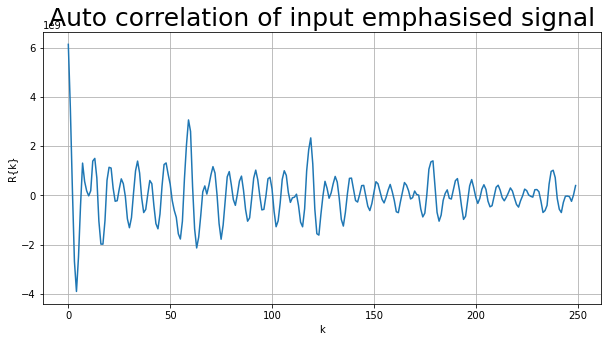

In [76]:
order=np.arange(2,250,1)
for i in range(0,248):
  a,e,r=lpc(emphasized_signal,order[i])
figure = plt.figure(figsize=[10,5])
plt.plot(r)
plt.title("Auto correlation of input emphasised signal",fontsize=25)
plt.xlabel('k')
plt.ylabel('R{k}')
plt.grid()




#For the above plot of auto correlation of emphasised signal, we can observe that first peak after k=0 is representing the pitch of the given signal.It is present at $T_{0}$ and further peaks are at $2T_{0},3T_{0}......$ and so on.

#Function to obtain residual error signal by inverse filtering of given input signal.

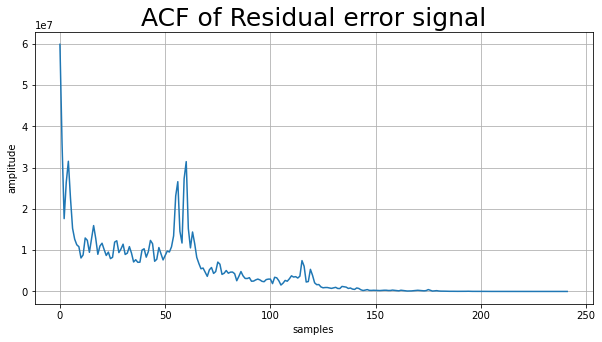

In [77]:
"""Obtaining predicted input signal from LP coeff's"""
s=np.reshape(time_x,(-1,1))
s_pred=np.zeros((s.shape[0],1))
for n in range(0,s_pred.shape[0]):
  for i in range(0,241):
    if n-i>0:
      s_pred[n]+=a[i]*s[n-i]
"""Calculating error signal by substracting predicted signal from original input"""
error=(s-s_pred)**2
e = np.squeeze(np.asarray(error))
a2,e2,r2=lpc(e,241)
figure = plt.figure(figsize=[10,5])
plt.plot(r2)
plt.title('ACF of Residual error signal',fontsize=25)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.grid()

#In this plot we can clearly see that the peak is at the same place as in the plot of ACF of input signal.

#This residual error signal represents the signal source ie the glottal pulse and here also the the peak obtained around n=55(approx) represents the pitch period of the uttered vowel /a/

#Plotting the magnitude response of residual error signal.

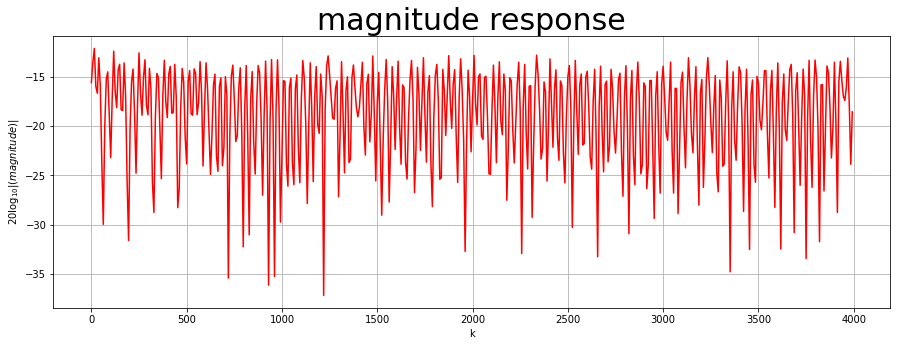

In [78]:
z,p,g=PoleZeroPlot([1],a2,False)
w, h = signal.freqz_zpk(z, p, g, fs=8000)
plots(w,20*np.log10(h),False)

#This plot represents the magnitude response in DB for the residual error signal obtained from the equation $e(n)=s(n)-s^{'}(n)$

where, $s^{'}(n)$ is the predicted  input signal

In [80]:
!jupyter nbconvert --to html CA2__213070001.ipynb

[NbConvertApp] WARNING | pattern u'CA2__213070001.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Ru